<a href="https://colab.research.google.com/github/seunghoonss/AI-HACKATHON/blob/main/BeautyGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive #Google drive 접근 권한 할당
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

# Load Models

In [4]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('/content/drive/MyDrive/makeup/shape_predictor_5_face_landmarks.dat')

# Load Images

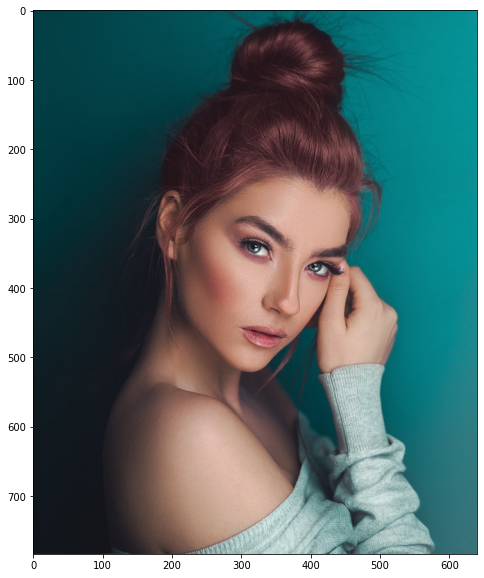

In [6]:
img = dlib.load_rgb_image('/content/drive/MyDrive/makeup/01.jpg')

plt.figure(figsize=(16, 10))
plt.imshow(img)

# Find Faces

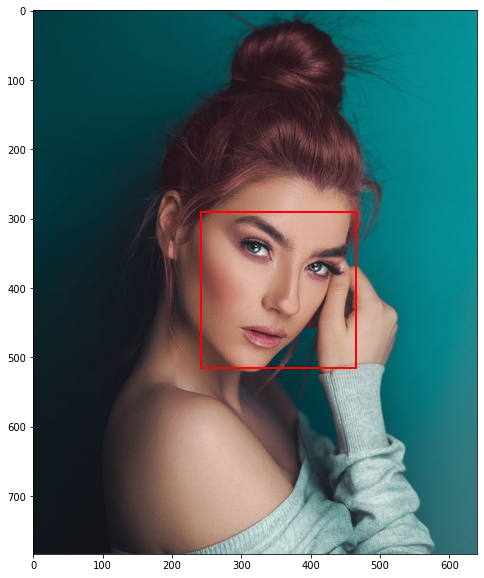

In [7]:
img_result = img.copy()

dets = detector(img, 1)

if len(dets) == 0:
    print('cannot find faces!')

fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets:
    x, y, w, h = det.left(), det.top(), det.width(), det.height()

    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img_result)

# Find Landmarks 5points

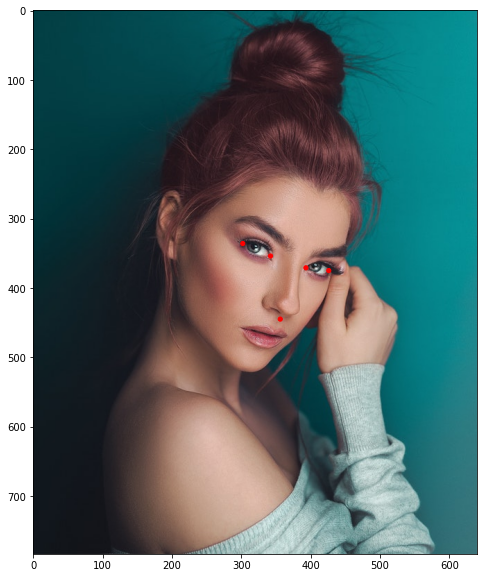

In [8]:
fig, ax = plt.subplots(1, figsize=(16, 10))

objs = dlib.full_object_detections()

for detection in dets:
    s = sp(img, detection)
    objs.append(s)
    
    for point in s.parts():
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

# Align Faces

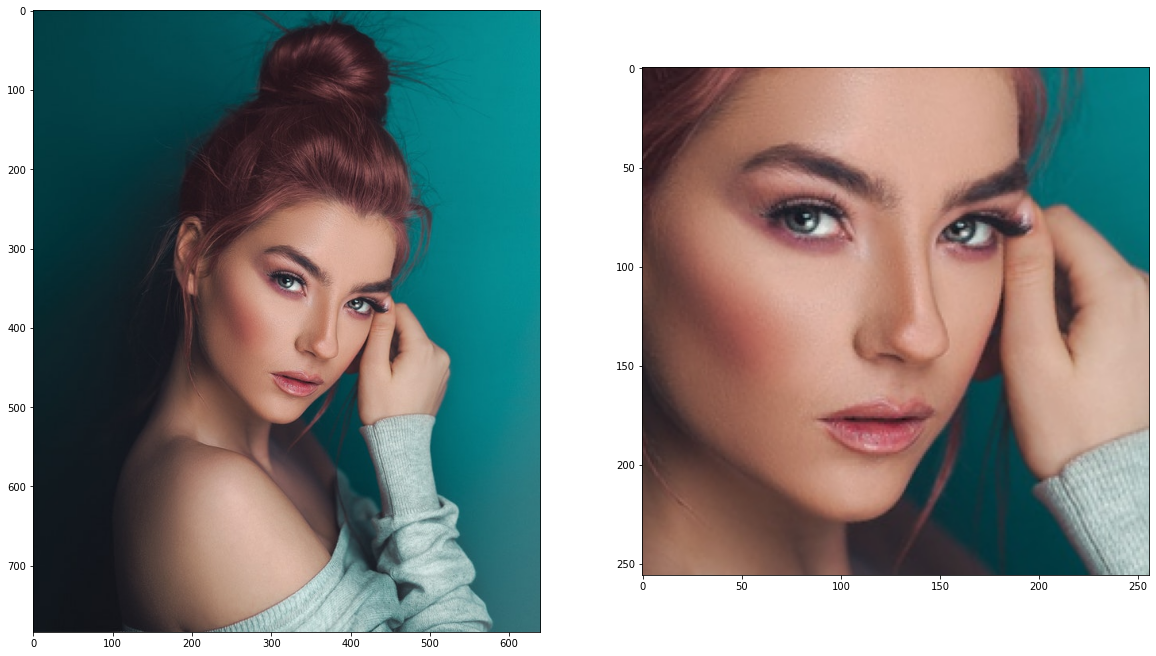

In [9]:
faces = dlib.get_face_chips(img, objs, size=256, padding=0.3)

fig, axes = plt.subplots(1, len(faces)+1, figsize=(20, 16))

axes[0].imshow(img)

for i, face in enumerate(faces):
    axes[i+1].imshow(face)

# Functionalize

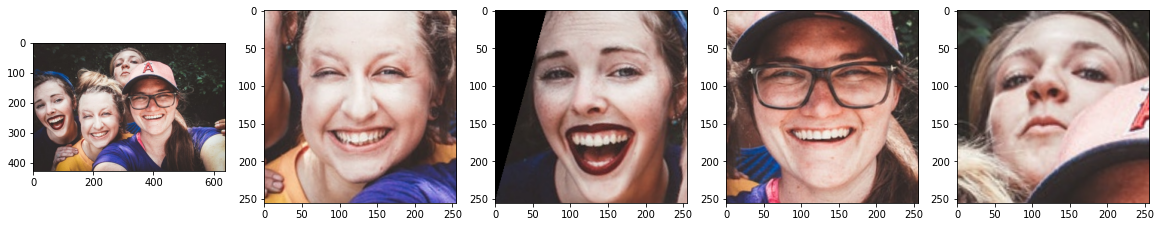

In [11]:
def align_faces(img):
    dets = detector(img, 1)
    
    objs = dlib.full_object_detections()

    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
        
    faces = dlib.get_face_chips(img, objs, size=256, padding=0.35)
    
    return faces

# test
test_img = dlib.load_rgb_image('/content/drive/MyDrive/makeup/02.jpg')

test_faces = align_faces(test_img)

fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(20, 16))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

# Load BeautyGAN Pretrained
- https://drive.google.com/drive/folders/1pgVqnF2-rnOxcUQ3SO4JwHUFTdiSe5t9

In [32]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [33]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph('/content/drive/MyDrive/makeup/models/model.meta')
saver.restore(sess, tf.train.latest_checkpoint('/content/drive/MyDrive/makeup/models'))
graph = tf.get_default_graph()

X = graph.get_tensor_by_name('X:0') # source
Y = graph.get_tensor_by_name('Y:0') # reference
Xs = graph.get_tensor_by_name('generator/xs:0') # output

# Preprocess and Postprocess Functions

In [34]:
def preprocess(img):
    return img.astype(np.float32) / 127.5 - 1.

def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8)

# Load Images

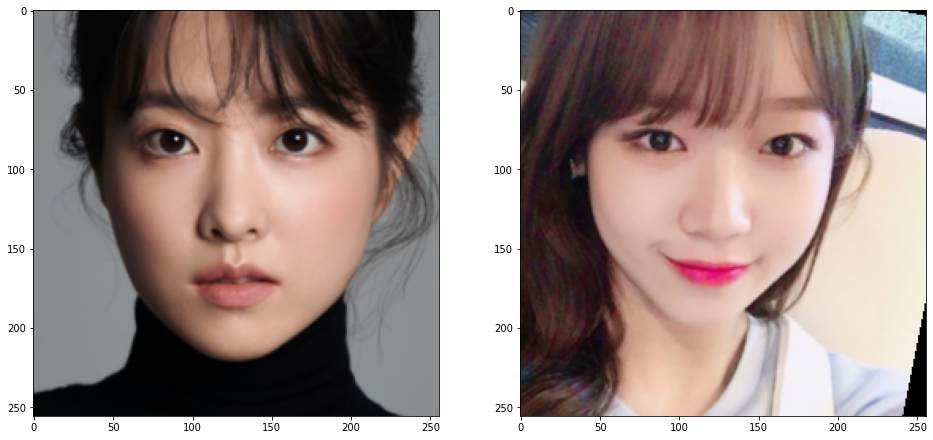

In [70]:
img1 = dlib.load_rgb_image('/content/drive/MyDrive/BeautyGAN/example/Boyoung3.png')
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image('/content/drive/MyDrive/BeautyGAN/makeup/yoojeoung1.jpg')
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])

# Run

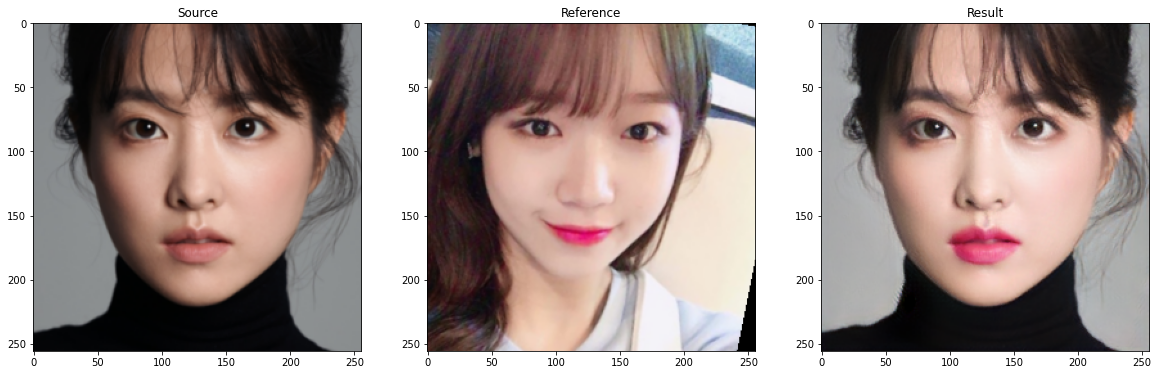

In [71]:
src_img = img1_faces[0]
ref_img = img2_faces[0]

X_img = preprocess(src_img)
X_img = np.expand_dims(X_img, axis=0)

Y_img = preprocess(ref_img)
Y_img = np.expand_dims(Y_img, axis=0)

output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img)
axes[1].set_title('Reference')
axes[1].imshow(ref_img)
axes[2].set_title('Result')
axes[2].imshow(output_img)